In [2]:
# importamos las librerias que vamos a utilizar en el notebook

import torch # libreria principal
import torch.nn as nn # libreria para redes neuronales
import torch.optim as optim # libreria para optimizacion
from torch.utils.data import DataLoader, Dataset # libreria para cargar los datos
import torchvision.transforms as transforms # libreria para transformar los datos
from torchvision import models # libreria para modelos pre-entrenados
from datasets import load_dataset # libreria para cargar los datos

In [3]:
# cargamos el dataset de Tiny ImageNet y lo guardamos en la variable dataset
dataset = load_dataset("zh-plus/tiny-imagenet")

In [4]:
# mostramos la estructura del dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

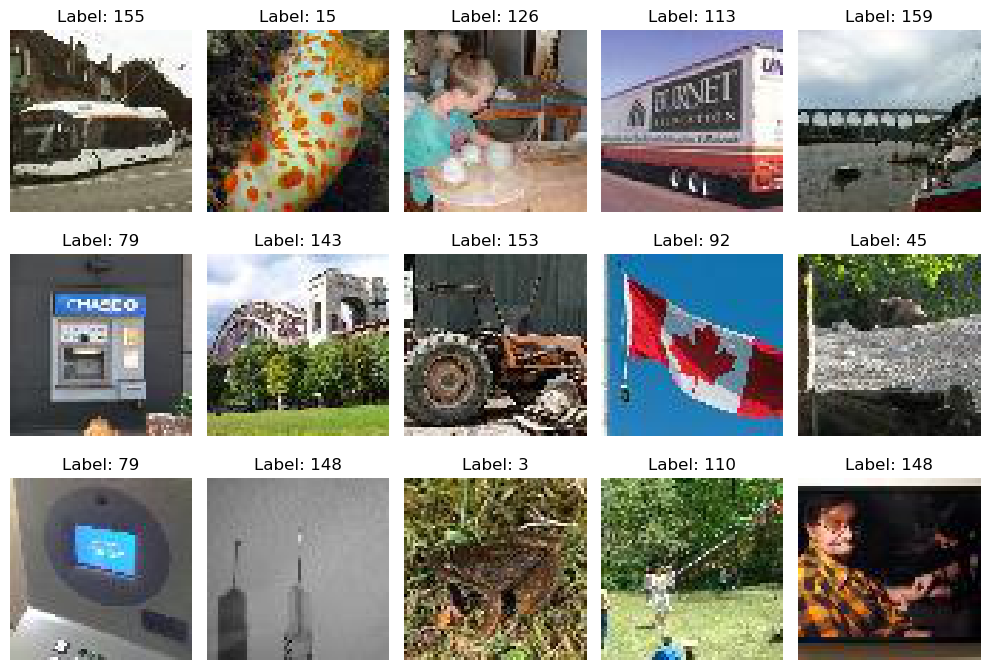

In [5]:
# graficamos algunas imagenes para saber con que tipo de datos estamos trabajando
import matplotlib.pyplot as plt
import random

# Configurar la tabla como 3 filas y 5 columnas
num_rows = 3
num_columns = 5

# Crear una figura y ejes para la tabla de imágenes
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 7))

for i in range(num_rows):
    for j in range(num_columns):
        # Elegir aleatoriamente una imagen del conjunto de entrenamiento
        random_index = random.randint(0, len(dataset['train']) - 1)
        random_image = dataset['train'][random_index]['image']
        random_label = dataset['train'][random_index]['label']

        # Mostrar la imagen en el subgráfico correspondiente
        axes[i, j].imshow(random_image, interpolation='nearest')
        axes[i, j].set_title(f"Label: {random_label}")
        axes[i, j].axis('off')  # Ocultar los ejes
# Ajustar el espacio entre los subgráficos para que se vean bien
plt.tight_layout()
# Mostrar la tabla de imágenes
plt.show()

In [6]:
# Definir una transformación para el preprocesamiento de imágenes.
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # pasar a escala de grises (3 canales)
    transforms.Resize((64, 64)), # redimensionar a 64x64
    transforms.ToTensor(), # convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalizar
])

In [7]:
# Defina su clase de conjunto de datos personalizado
class CustomDataset(Dataset):
    def __init__(self, dataset, split, transform=None):
        self.X = dataset[split]['image'] # cargar imágenes
        self.y = dataset[split]['label'] # cargar etiquetas
        self.transform = transform

    # Devuelve el número de muestras en el conjunto de datos.
    def __len__(self):
        return len(self.X)

    # Devuelve una muestra del conjunto de datos en la posición index.
    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [8]:
# Cree instancias de su conjunto de datos personalizado para divisiones de entrenamiento y prueba
train_dataset = CustomDataset(dataset, 'train', transform=transform)
test_dataset = CustomDataset(dataset, 'valid', transform=transform)

# Crear cargadores de datos para cargar los datos.
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# miraramos el tamaño de los datos de entrenamiento por batches (1er batch) y el tamaño de las etiquetas 
for batch_idx, (X, y) in enumerate(train_loader):
    print(X.shape)
    print(y.shape)
    break

torch.Size([64, 3, 64, 64])
torch.Size([64])


In [25]:
# Cargar el modelo preentrenado resnext50_32x4d
model = models.resnext50_32x4d(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [27]:
# cambiamos la capa de salida de la red por una capa lineal con 200 neuronas (número de clases)
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [28]:
# cambiar la última capa de salida de la red para que coincida con el número de clases en el conjunto de datos
model._fc = nn.Linear(2048, 200) # cambiamos a 200 clases de salida

In [29]:
# miramos la nueva arquitectura de la red neuronal convolucional pre-entrenada (ResNet50)
model._fc

Linear(in_features=2048, out_features=200, bias=True)

In [30]:
# importamos sklearn para calcular la precisión de la red neuronal
from sklearn.metrics import accuracy_score

# Define a loss function and an optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.0001) # precision de un batch 45.65% 1min 18s
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00001) # precision de un batch 45.45% 1m 18s
#optimizer = optim.Adamax(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001) # precision de un batch 50.89% 1m 38s

# Train the model on your dataset
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        Y_hat = model(X)
        loss = criterion(Y_hat, y)
        loss.backward()
        optimizer.step()

    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            Y_hat = model(X)
            _, predicted = torch.max(Y_hat, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/5, Loss: 2.4088, Test Accuracy: 45.61%
Epoch 2/5, Loss: 1.7172, Test Accuracy: 50.31%
Epoch 3/5, Loss: 1.5547, Test Accuracy: 50.77%
Epoch 4/5, Loss: 1.0289, Test Accuracy: 50.11%
Epoch 5/5, Loss: 0.9213, Test Accuracy: 49.96%


In [79]:
# guardamos el modelo
torch.save(model.state_dict(), 'models/modelo_pre_entrenado_efficientnet-b0.pth')

In [ ]:
# cargamos el modelo
# definimos el modelo
model = models.resnext50_32x4d(pretrained=True)
model._fc = nn.Linear(2048, 200) # cambiamos a 200 clases de salida
model.load_state_dict(torch.load('models/modelo_pre_entrenado_resnet50.pth'))
model.eval()

In [ ]:
# guardamos el modelo pre entrenado de resnext50_32x4d
torch.save(model_rx.state_dict(), 'models/modelo_pre_entrenado_resnext50_32x4d.pth')